In [1]:
import torch
import models
import functions
from data_utils import load_mnist
import matplotlib.pyplot as plt

In [2]:
device = "cpu"
X, y = load_mnist(device)

In [3]:
# One-hot encode the labels and normalize the pixel intensities to [-1, 1]
yhot = functions.one_hot_encode(y, 10)
Xnorm = 2*(X/255 - 1/2)

X_train, y_train = Xnorm[:60000], yhot[:60000]
X_val, y_val = Xnorm[60000:], yhot[60000:]

In [5]:
# Initialize dense network 
input_size = X.shape[-1]
output_size = 10
mlp = models.MLP([input_size, 300, 100, 100, 100, output_size], device=device)
print(mlp)

Linear layer with input->output = 784->300. Total params = 235500
Linear layer with input->output = 300->100. Total params = 30100
Linear layer with input->output = 100->100. Total params = 10100
Linear layer with input->output = 100->100. Total params = 10100
Linear layer with input->output = 100->10. Total params = 1010


In [7]:
def train(model, X, y, batch_size, epochs, learning_rate=1e-2, X_valid=None, y_valid=None):
    #Train with stochastic SGD on mini-batches with fixed learning rate

    train_loss = model.get_classification_accuracy(X_train, y_train, batch_size=100)
    train_accuracy_history = [train_loss]
    valid_accuracy_history = []
    if X_valid is not None:
        valid_loss = model.get_classification_accuracy(X_val, y_val, batch_size=100)
        valid_accuracy_history.append(valid_loss)

    for epoch in range(epochs): 
        running_loss = 0.0

        # Randomize the order of the data
        indices = torch.randperm(X.shape[0])
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        n_batches = X.shape[0]//batch_size

        for i in range(n_batches): 
            start = i * batch_size 
            end = min(start + batch_size, X.shape[0])
            X_batch = X_shuffled[start:end].to(device)
            y_batch = y_shuffled[start:end].to(device)
            pred_batch = model(X_batch)

            loss = functions.cross_entropy(pred_batch, y_batch)

            # Zero out gradients before backpropagation
            for param in model.parameters():
                if param.grad is not None:
                    param.grad.zero_()
            loss.backward()

            with torch.no_grad(): 
                for param in model.parameters():
                        param -= learning_rate * param.grad

            running_loss += loss.item()
            if i % 300 == 99:    # print every 100 mini-batches
                print(f'[Epoch: {epoch + 1}, Batch: {i + 1}]/{n_batches} \
                      loss: {running_loss / 100:.3f}')
                running_loss = 0.0


        train_loss = model.get_classification_accuracy(X, y, batch_size=100)
        train_accuracy_history.append(train_loss)
        if X_valid is not None:
            valid_loss = model.get_classification_accuracy(X_valid, y_valid, batch_size=100)
            valid_accuracy_history.append(valid_loss)

        print(f'====================')
        epochstr = f'[Epoch: {epoch + 1}, test accuracy: {train_loss:.3f}' 
        if X_valid is not None:
            epochstr =epochstr+ f', validation accuracy: {valid_loss:.3f}'
        print(epochstr)
        print(f'====================')

    return train_accuracy_history, valid_accuracy_history    

In [8]:
train_hist, val_hist = train(mlp, X_train, y_train, batch_size=64, epochs=20, 
                             X_valid=X_val, y_valid=y_val, learning_rate=1e-2)

[Epoch: 1, Batch: 100]/937                       loss: 1.363
[Epoch: 1, Batch: 400]/937                       loss: 1.542
[Epoch: 1, Batch: 700]/937                       loss: 1.066
[Epoch: 1, test accuracy: 0.919, validation accuracy: 0.925
[Epoch: 2, Batch: 100]/937                       loss: 0.265
[Epoch: 2, Batch: 400]/937                       loss: 0.765
[Epoch: 2, Batch: 700]/937                       loss: 0.668
[Epoch: 2, test accuracy: 0.942, validation accuracy: 0.942
[Epoch: 3, Batch: 100]/937                       loss: 0.195
[Epoch: 3, Batch: 400]/937                       loss: 0.572
[Epoch: 3, Batch: 700]/937                       loss: 0.548
[Epoch: 3, test accuracy: 0.948, validation accuracy: 0.944
[Epoch: 4, Batch: 100]/937                       loss: 0.162
[Epoch: 4, Batch: 400]/937                       loss: 0.458
[Epoch: 4, Batch: 700]/937                       loss: 0.440
[Epoch: 4, test accuracy: 0.959, validation accuracy: 0.953
[Epoch: 5, Batch: 100]/937  

<function matplotlib.pyplot.show(close=None, block=None)>

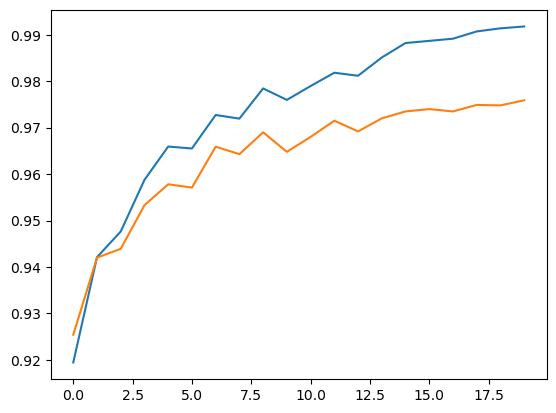

In [9]:
plt.plot(train_hist[1:])
plt.plot(val_hist[1:])
plt.show